# Bibliotheken

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import os
from sklearn.ensemble import IsolationForest

# 1. Daten aus CSV-File in Datenbank speichern

In [3]:
# Pfad zur CSV-Datei
csv_file_path = 'Daten.csv'

# Lese die CSV-Datei mit Semikolon als Trennzeichen
data = pd.read_csv(csv_file_path, sep=';')

# Zeige Informationen über die Daten an
print("\nInformationen zum Datensatz:")
print(f"Anzahl Zeilen: {data.shape[0]}")
print(f"Anzahl Spalten: {data.shape[1]}")
print("\nSpaltennamen:")
print(data.columns.tolist())

# Verbindung zur SQLite-Datenbank herstellen (oder erstellen, falls sie nicht existiert)
db_path = 'datenbank.db'
conn = sqlite3.connect(db_path)

# Daten in die SQL-Datenbank schreiben
table_name = 'daten_tabelle'
data.to_sql(table_name, conn, if_exists='replace', index=False)

print(f"\nDaten wurden erfolgreich in die Tabelle '{table_name}' der Datenbank '{db_path}' gespeichert.")

# Verbindung schließen
conn.close()


Informationen zum Datensatz:
Anzahl Zeilen: 1000000
Anzahl Spalten: 6

Spaltennamen:
['TimeStamp', 'ActualPos', 'ActualForce', 'Nahtnummer', 'LaserPwr', 'Befehl']

Daten wurden erfolgreich in die Tabelle 'daten_tabelle' der Datenbank 'datenbank.db' gespeichert.


# 2. Daten aufbereiten / bereinigen

In [4]:
# Verbindung zur ursprünglichen SQLite-Datenbank herstellen
conn = sqlite3.connect('datenbank.db')

# Tabelle aus der Datenbank lesen
table_name = 'daten_tabelle'
data = pd.read_sql(f"SELECT * FROM {table_name}", conn)

# Datentypen der SQL-Spalten anzeigen
print("\nDatentypen der SQL-Spalten:")
cursor = conn.cursor()
cursor.execute(f"PRAGMA table_info({table_name})")
columns_info = cursor.fetchall()
for column in columns_info:
    print(f"Spalte: {column[1]}, Datentyp: {column[2]}")

# Anzahl der ursprünglichen Zeilen und Spalten
original_rows, original_columns = data.shape
print(f"\nUrsprüngliche Daten: {original_rows} Zeilen, {original_columns} Spalten")

# Bereinigung der Daten
# 1. Entferne Duplikate
data = data.drop_duplicates()

# 2. Entferne Zeilen mit fehlenden Werten
data = data.dropna()

# 3. Optional: Entferne Spalten mit zu vielen fehlenden Werten (z. B. mehr als 50%)
# threshold = 0.5 * len(data)
# data = data.loc[:, data.isnull().sum() < threshold]

# Sicherstellen, dass die Spalte 'ActualPos' als Zahl oder Kommazahl gespeichert wird
if 'ActualPos' in data.columns:
    data['ActualPos'] = pd.to_numeric(data['ActualPos'], errors='coerce')  # Konvertiere in Zahl (NaN bei Fehlern)

# Anzahl der bereinigten Zeilen und Spalten
cleaned_rows, cleaned_columns = data.shape
print(f"\nBereinigte Daten: {cleaned_rows} Zeilen, {cleaned_columns} Spalten")

# Anzahl der entfernten Zeilen und Spalten berechnen
removed_rows = original_rows - cleaned_rows
removed_columns = original_columns - cleaned_columns
print(f"\nAnzahl der entfernten Zeilen: {removed_rows}")
print(f"Anzahl der entfernten Spalten: {removed_columns}")

# Verbindung zur neuen SQLite-Datenbank herstellen
clean_conn = sqlite3.connect('datenbank_clean.db')

# Bereinigte Daten in die neue Datenbank schreiben
clean_table_name = 'bereinigte_daten'

# Tabelle mit expliziten Datentypen erstellen
data.to_sql(clean_table_name, clean_conn, if_exists='replace', index=False, dtype={
    'ActualPos': 'REAL'  # Erzwinge den Datentyp REAL für die Spalte 'ActualPos'
})

print(f"\nBereinigte Daten wurden erfolgreich in die neue Datenbank 'datenbank_clean.db' und Tabelle '{clean_table_name}' gespeichert.")

# Datentypen der SQL-Spalten in der neuen Tabelle anzeigen
print("\nDatentypen der SQL-Spalten in der bereinigten Tabelle:")
cursor = clean_conn.cursor()
cursor.execute(f"PRAGMA table_info({clean_table_name})")
clean_columns_info = cursor.fetchall()
for column in clean_columns_info:
    print(f"Spalte: {column[1]}, Datentyp: {column[2]}")

# Verbindungen schließen
conn.close()
clean_conn.close()


Datentypen der SQL-Spalten:
Spalte: TimeStamp, Datentyp: TEXT
Spalte: ActualPos, Datentyp: TEXT
Spalte: ActualForce, Datentyp: INTEGER
Spalte: Nahtnummer, Datentyp: TEXT
Spalte: LaserPwr, Datentyp: INTEGER
Spalte: Befehl, Datentyp: TEXT

Ursprüngliche Daten: 1000000 Zeilen, 6 Spalten

Bereinigte Daten: 994398 Zeilen, 6 Spalten

Anzahl der entfernten Zeilen: 5602
Anzahl der entfernten Spalten: 0

Bereinigte Daten wurden erfolgreich in die neue Datenbank 'datenbank_clean.db' und Tabelle 'bereinigte_daten' gespeichert.

Datentypen der SQL-Spalten in der bereinigten Tabelle:
Spalte: TimeStamp, Datentyp: TEXT
Spalte: ActualPos, Datentyp: REAL
Spalte: ActualForce, Datentyp: INTEGER
Spalte: Nahtnummer, Datentyp: TEXT
Spalte: LaserPwr, Datentyp: INTEGER
Spalte: Befehl, Datentyp: TEXT


# 3. Visualisierung der Daten / Teil - 1

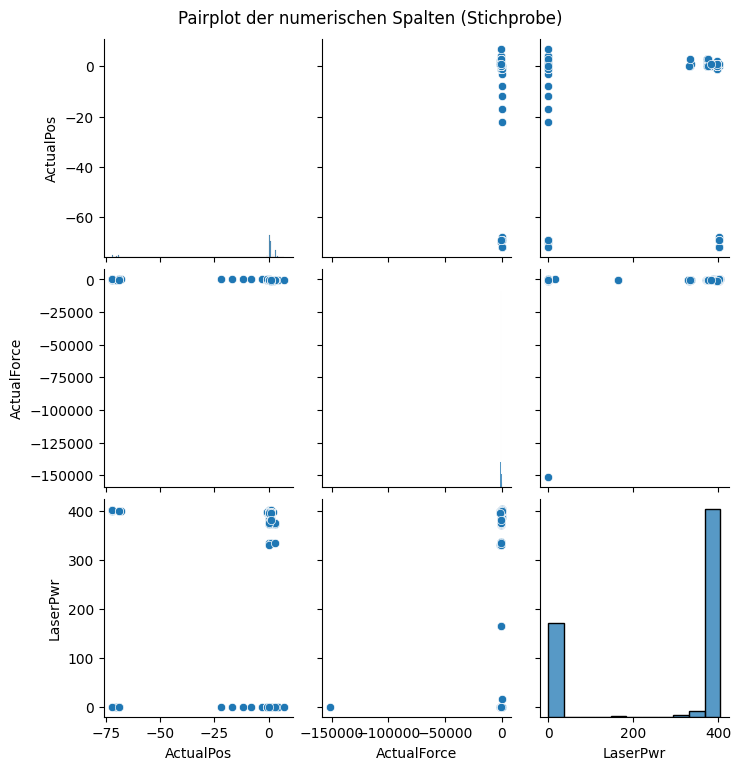

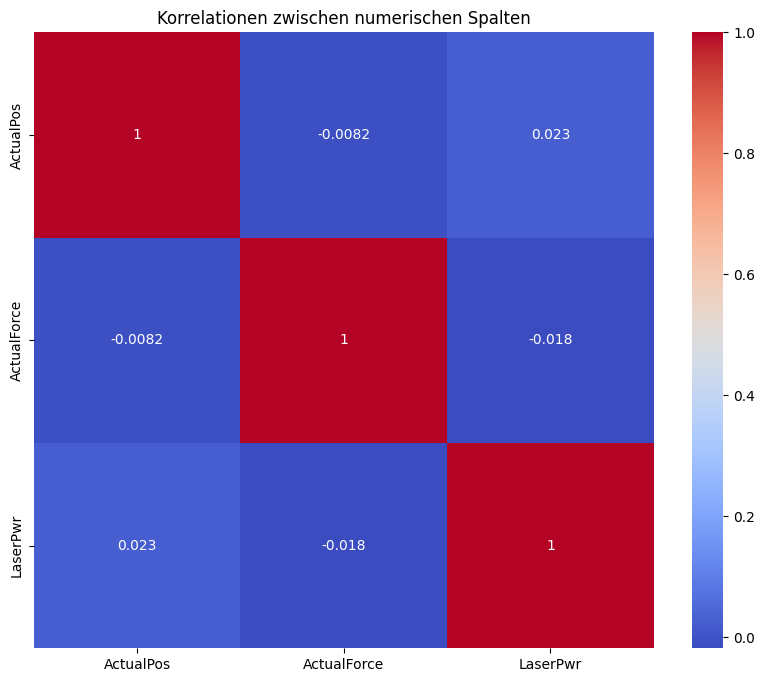

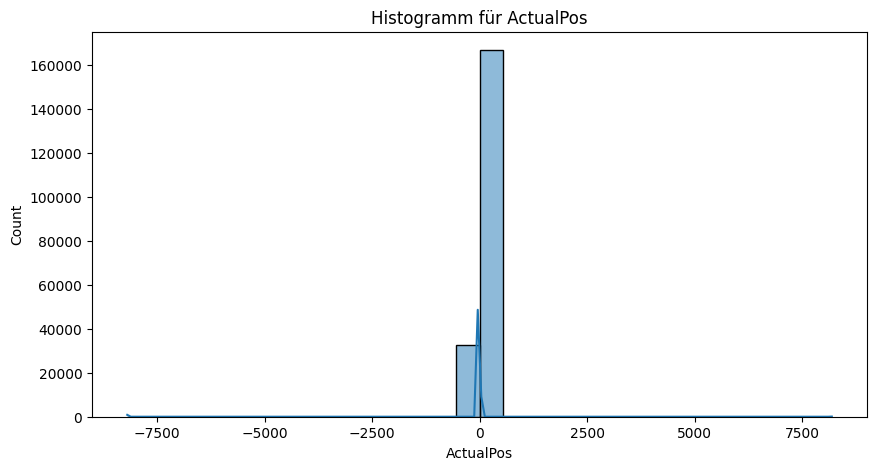

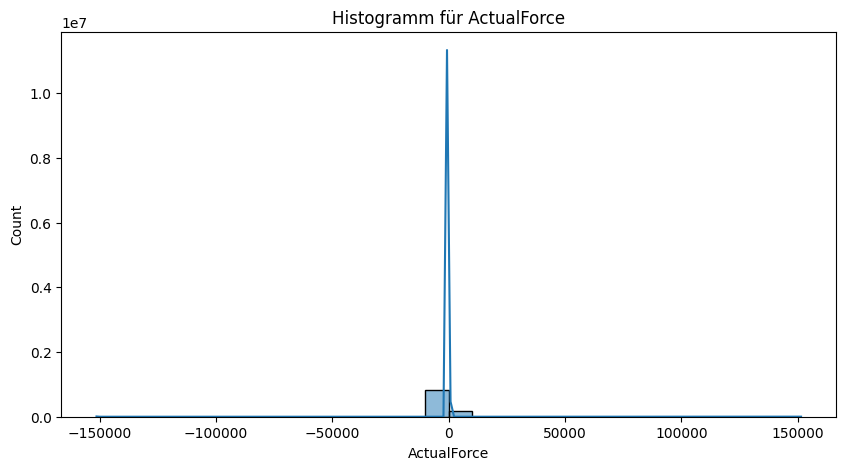

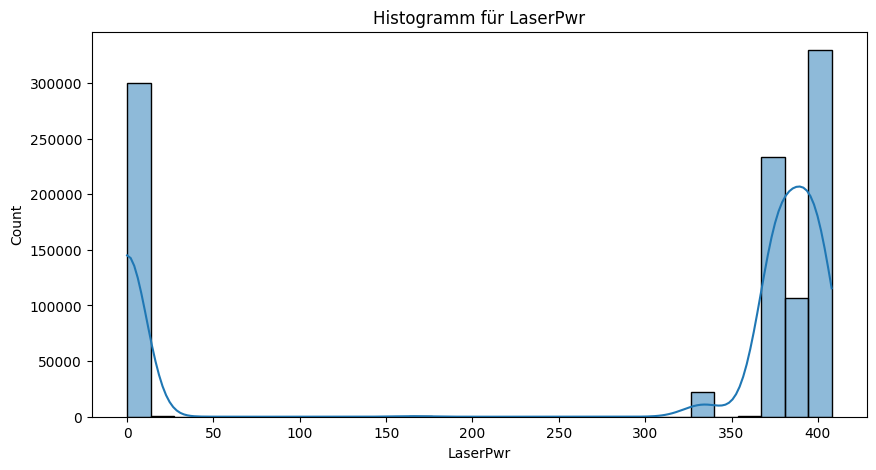


Anzahl der gefundenen Anomalien in der Stichprobe: 249


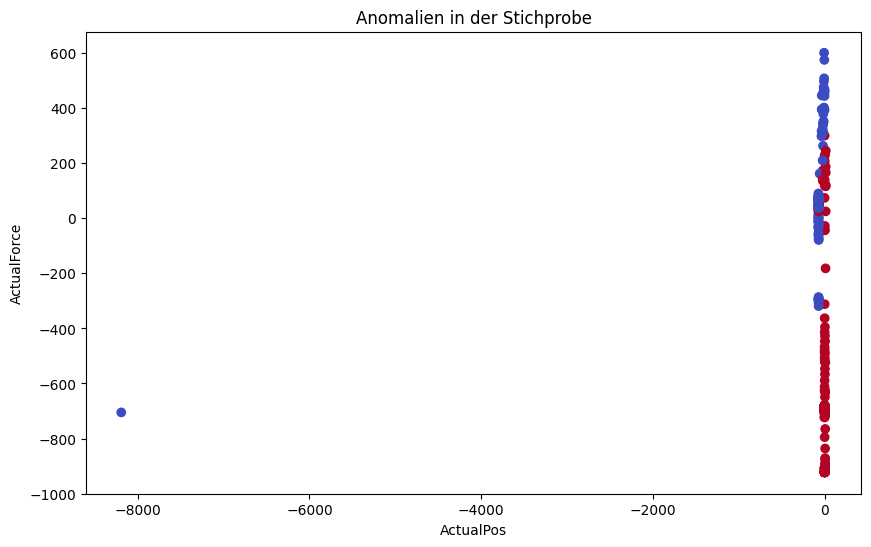

In [5]:
# Verbindung zur bereinigten SQLite-Datenbank herstellen
conn = sqlite3.connect('datenbank_clean.db')

# Tabelle aus der Datenbank lesen
clean_table_name = 'bereinigte_daten'
data = pd.read_sql(f"SELECT * FROM {clean_table_name}", conn)

# Verbindung schließen
conn.close()

# Prüfen, ob numerische Spalten vorhanden sind
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Methode 1: Stichprobe für Visualisierung
def visualize_sample(data, numerical_columns, sample_size=10000):
    if len(numerical_columns) > 0:
        sample_data = data.sample(n=sample_size, random_state=42)
        sns.pairplot(sample_data[numerical_columns])
        plt.suptitle("Pairplot der numerischen Spalten (Stichprobe)", y=1.02)
        plt.show()
    else:
        print("Keine numerischen Spalten für die Visualisierung gefunden.")

# Methode 2: Alternative Visualisierungen
def alternative_visualizations(data, numerical_columns):
    if len(numerical_columns) > 0:
        # Heatmap der Korrelationen
        plt.figure(figsize=(10, 8))
        sns.heatmap(data[numerical_columns].corr(), annot=True, cmap='coolwarm')
        plt.title("Korrelationen zwischen numerischen Spalten")
        plt.show()

        # Histogramme für numerische Spalten
        for column in numerical_columns:
            plt.figure(figsize=(10, 5))
            sns.histplot(data[column], bins=30, kde=True)
            plt.title(f"Histogramm für {column}")
            plt.show()
    else:
        print("Keine numerischen Spalten für alternative Visualisierungen gefunden.")

# Methode 3: Anomalieerkennung mit Isolation Forest
def detect_anomalies(data, numerical_columns, sample_size=5000, contamination=0.05):
    if len(numerical_columns) > 0:
        # Stichprobe für Anomalieerkennung
        sample_data = data.sample(n=sample_size, random_state=42)

        # Isolation Forest-Modell trainieren
        isolation_forest = IsolationForest(contamination=contamination, random_state=42)
        sample_data['anomaly'] = isolation_forest.fit_predict(sample_data[numerical_columns])

        # Anomalien markieren (-1 = Anomalie, 1 = normal)
        anomalies = sample_data[sample_data['anomaly'] == -1]
        print(f"\nAnzahl der gefundenen Anomalien in der Stichprobe: {len(anomalies)}")

        # Scatterplot der Anomalien (falls mindestens zwei numerische Spalten vorhanden sind)
        if len(numerical_columns) >= 2:
            plt.figure(figsize=(10, 6))
            plt.scatter(sample_data[numerical_columns[0]], sample_data[numerical_columns[1]], c=sample_data['anomaly'], cmap='coolwarm')
            plt.title("Anomalien in der Stichprobe")
            plt.xlabel(numerical_columns[0])
            plt.ylabel(numerical_columns[1])
            plt.show()
    else:
        print("Keine numerischen Spalten für die Anomalieerkennung gefunden.")

# Aufruf der Methoden
visualize_sample(data, numerical_columns, sample_size=1000)
alternative_visualizations(data, numerical_columns)
detect_anomalies(data, numerical_columns, sample_size=5000, contamination=0.05)

# 3. Visualisierung der Daten / Teil - 2

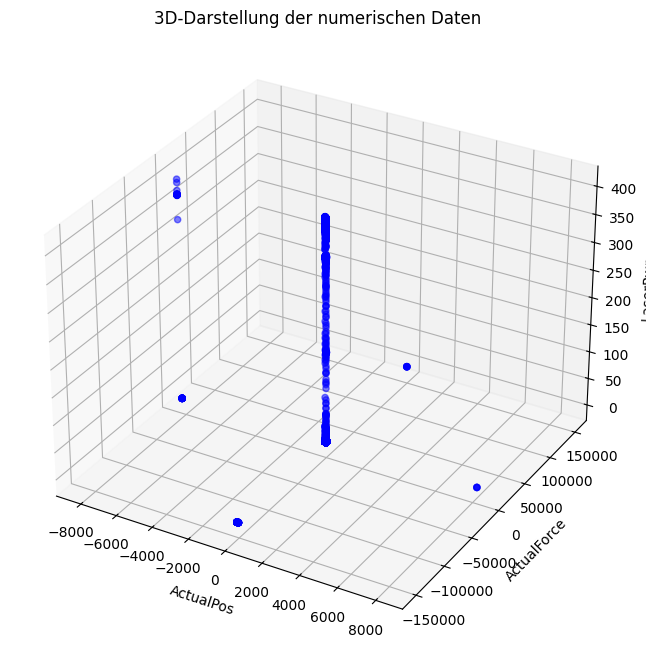

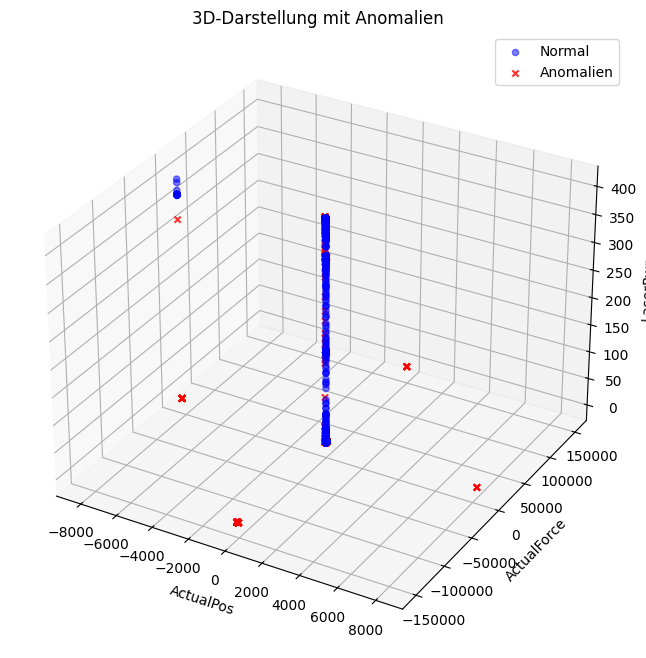

In [6]:
# Verbindung zur SQLite-Datenbank herstellen
conn = sqlite3.connect('datenbank_clean.db')

# Tabelle mit bereinigten Daten laden
table_name = 'bereinigte_daten'
data = pd.read_sql(f"SELECT * FROM {table_name}", conn)

# Verbindung schließen
conn.close()

# Nur numerische Spalten auswählen
numeric_data = data.select_dtypes(include=[np.number])

# Überprüfen, ob mindestens drei numerische Spalten vorhanden sind
if numeric_data.shape[1] < 3:
    raise ValueError("Es werden mindestens drei numerische Spalten für die 3D-Darstellung benötigt.")

# Die ersten drei numerischen Spalten für die 3D-Darstellung auswählen
x_col, y_col, z_col = numeric_data.columns[:3]

# 3D-Plot der Daten
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(numeric_data[x_col], numeric_data[y_col], numeric_data[z_col], c='b', marker='o', alpha=0.5)
ax.set_xlabel(x_col)
ax.set_ylabel(y_col)
ax.set_zlabel(z_col)
ax.set_title("3D-Darstellung der numerischen Daten")
plt.show()

# Anomalien mit IsolationForest erkennen
iso_forest = IsolationForest(contamination=0.05, random_state=42)
numeric_data['anomaly'] = iso_forest.fit_predict(numeric_data)

# Anomalien markieren
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Normalpunkte (anomaly = 1)
normal_data = numeric_data[numeric_data['anomaly'] == 1]
ax.scatter(normal_data[x_col], normal_data[y_col], normal_data[z_col], c='b', marker='o', alpha=0.5, label='Normal')

# Anomalien (anomaly = -1)
anomalies = numeric_data[numeric_data['anomaly'] == -1]
ax.scatter(anomalies[x_col], anomalies[y_col], anomalies[z_col], c='r', marker='x', alpha=0.8, label='Anomalien')

ax.set_xlabel(x_col)
ax.set_ylabel(y_col)
ax.set_zlabel(z_col)
ax.set_title("3D-Darstellung mit Anomalien")
ax.legend()
plt.show()

# 3. Visualisierung der Daten / Teil - 3

Verfügbare Tabellen: [('bereinigte_daten',)]


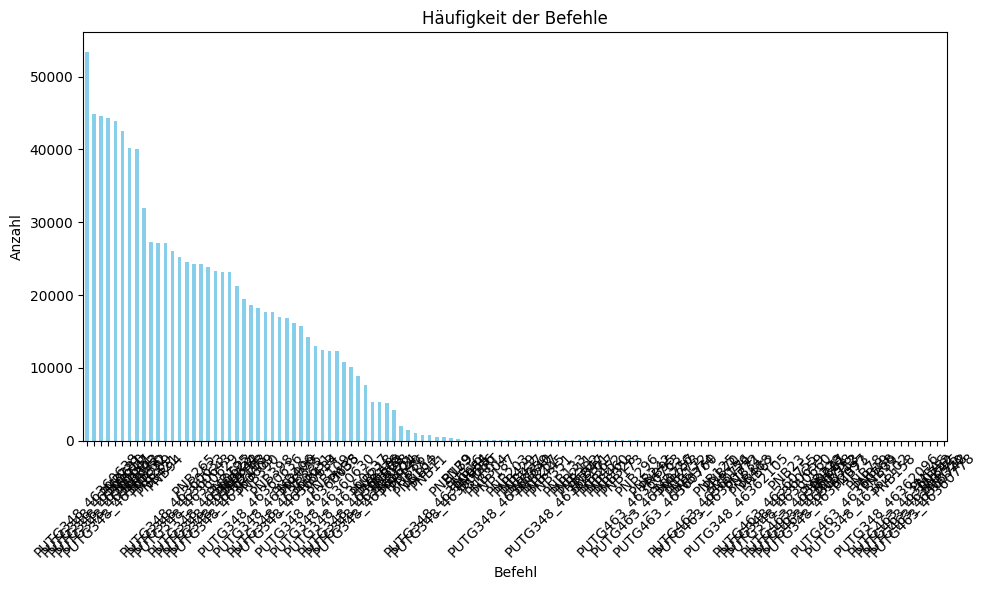

In [7]:
# Verbindung zur SQLite-Datenbank herstellen
db_path = 'datenbank_clean.db'
conn = sqlite3.connect(db_path)

# Tabellen in der Datenbank auflisten
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Verfügbare Tabellen:", tables)

# Daten aus der Tabelle 'bereinigte_daten' laden
query = "SELECT * FROM bereinigte_daten"  # Tabellennamen angepasst
df = pd.read_sql_query(query, conn)

# Überprüfen, ob die Spalte "Befehle" existiert
if 'Befehl' in df.columns:
    # Häufigkeitsanalyse der Spalte "Befehle"
    befehle_counts = df['Befehl'].value_counts()

    # Visualisierung: Balkendiagramm
    plt.figure(figsize=(10, 6))
    befehle_counts.plot(kind='bar', color='skyblue')
    plt.title('Häufigkeit der Befehle')
    plt.xlabel('Befehl')
    plt.ylabel('Anzahl')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Die Spalte 'Befehle' ist nicht in den Daten vorhanden.")

# Verbindung zur Datenbank schließen
conn.close()

# 3. Visualisierung der Daten / Teil - 4

Verfügbare Tabellen: [('bereinigte_daten',)]


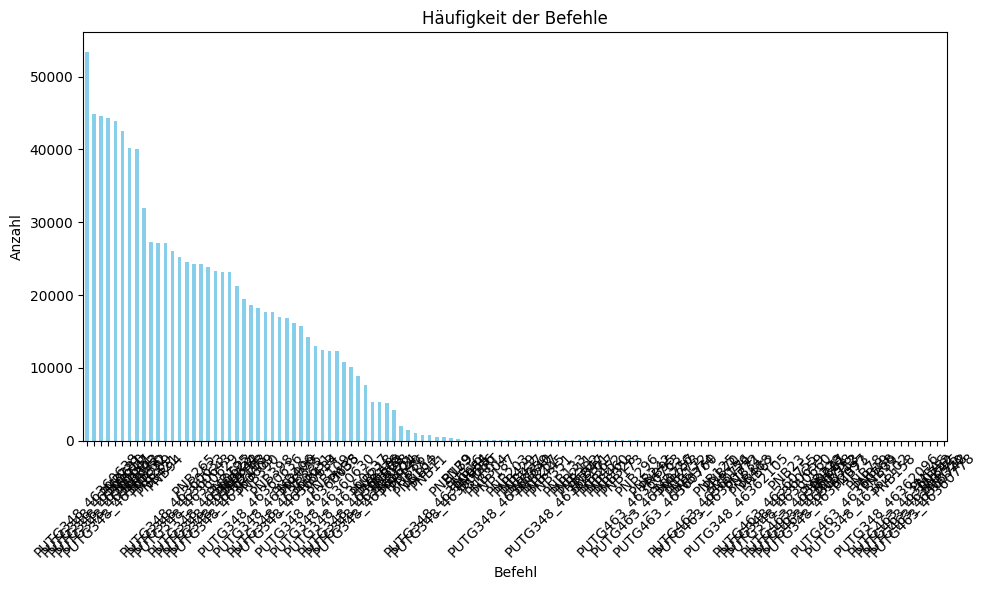

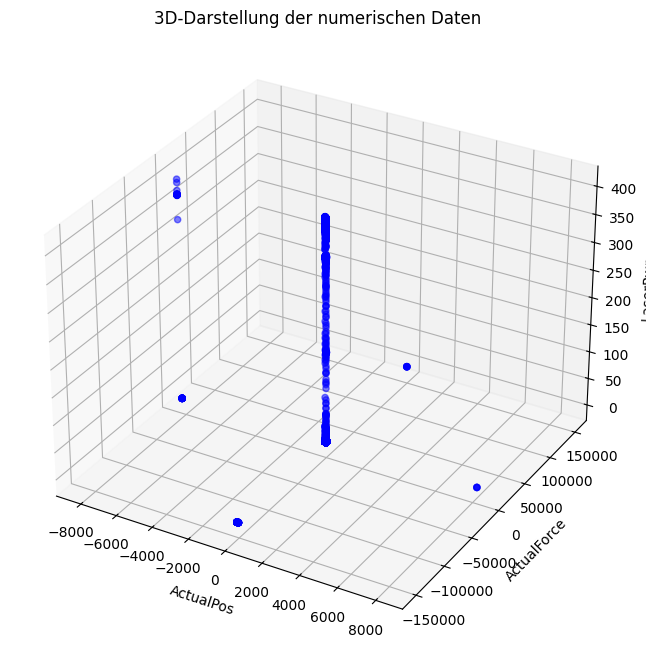

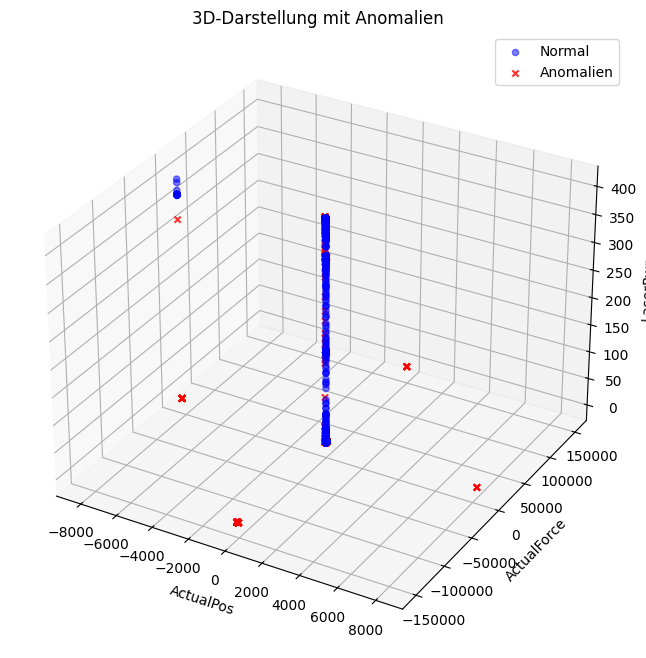

In [8]:
# Verbindung zur SQLite-Datenbank herstellen
db_path = 'datenbank_clean.db'
conn = sqlite3.connect(db_path)

# Tabellen in der Datenbank auflisten
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Verfügbare Tabellen:", tables)

# Daten aus der Tabelle 'bereinigte_daten' laden
table_name = 'bereinigte_daten'
data = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)

# Überprüfen, ob die Spalte "Befehl" existiert
if 'Befehl' in data.columns:
    # Häufigkeitsanalyse der Spalte "Befehl"
    befehle_counts = data['Befehl'].value_counts()

    # Visualisierung: Balkendiagramm
    plt.figure(figsize=(10, 6))
    befehle_counts.plot(kind='bar', color='skyblue')
    plt.title('Häufigkeit der Befehle')
    plt.xlabel('Befehl')
    plt.ylabel('Anzahl')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Die Spalte 'Befehl' ist nicht in den Daten vorhanden.")

# Nur numerische Spalten auswählen
numeric_data = data.select_dtypes(include=[np.number])

# Überprüfen, ob mindestens drei numerische Spalten vorhanden sind
if numeric_data.shape[1] < 3:
    raise ValueError("Es werden mindestens drei numerische Spalten für die 3D-Darstellung benötigt.")

# Die ersten drei numerischen Spalten für die 3D-Darstellung auswählen
x_col, y_col, z_col = numeric_data.columns[:3]

# 3D-Plot der Daten
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(numeric_data[x_col], numeric_data[y_col], numeric_data[z_col], c='b', marker='o', alpha=0.5)
ax.set_xlabel(x_col)
ax.set_ylabel(y_col)
ax.set_zlabel(z_col)
ax.set_title("3D-Darstellung der numerischen Daten")
plt.show()

# Anomalien mit IsolationForest erkennen
iso_forest = IsolationForest(contamination=0.05, random_state=42)
numeric_data['anomaly'] = iso_forest.fit_predict(numeric_data)

# Anomalien markieren
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Normalpunkte (anomaly = 1)
normal_data = numeric_data[numeric_data['anomaly'] == 1]
ax.scatter(normal_data[x_col], normal_data[y_col], normal_data[z_col], c='b', marker='o', alpha=0.5, label='Normal')

# Anomalien (anomaly = -1)
anomalies = numeric_data[numeric_data['anomaly'] == -1]
ax.scatter(anomalies[x_col], anomalies[y_col], anomalies[z_col], c='r', marker='x', alpha=0.8, label='Anomalien')

ax.set_xlabel(x_col)
ax.set_ylabel(y_col)
ax.set_zlabel(z_col)
ax.set_title("3D-Darstellung mit Anomalien")
ax.legend()
plt.show()

# Verbindung zur Datenbank schließen
conn.close()

# 3. Visualisierung der Daten / Teil - 5

Verfügbare Tabellen: [('bereinigte_daten',)]


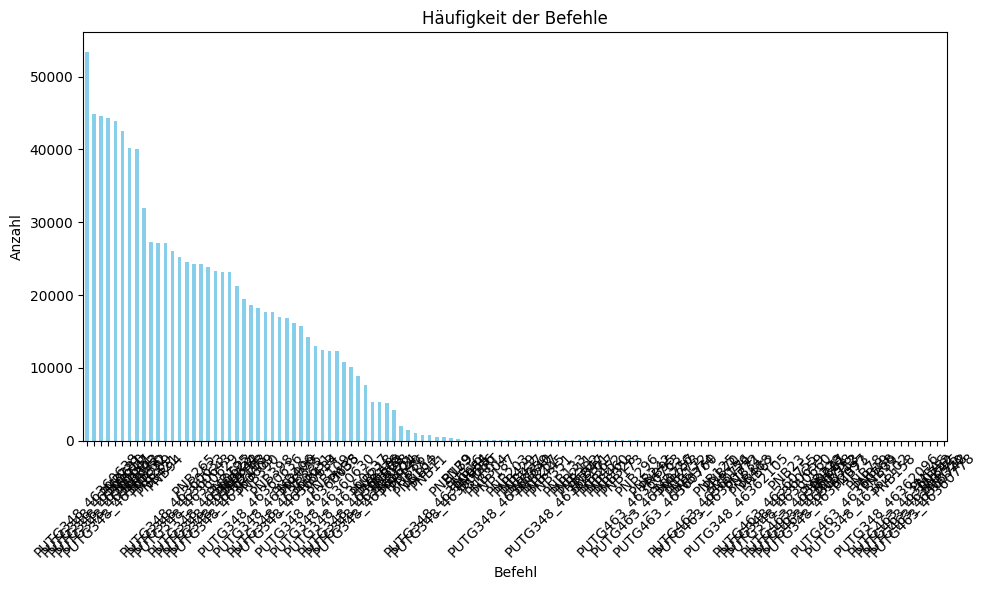

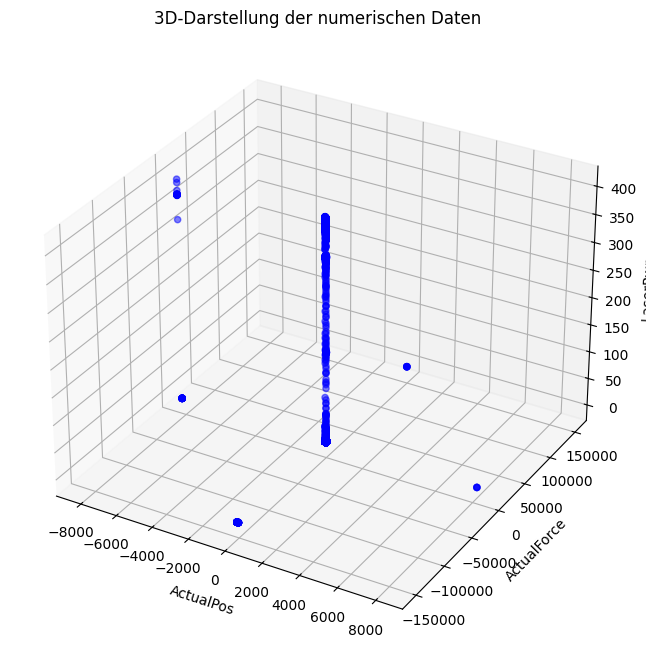

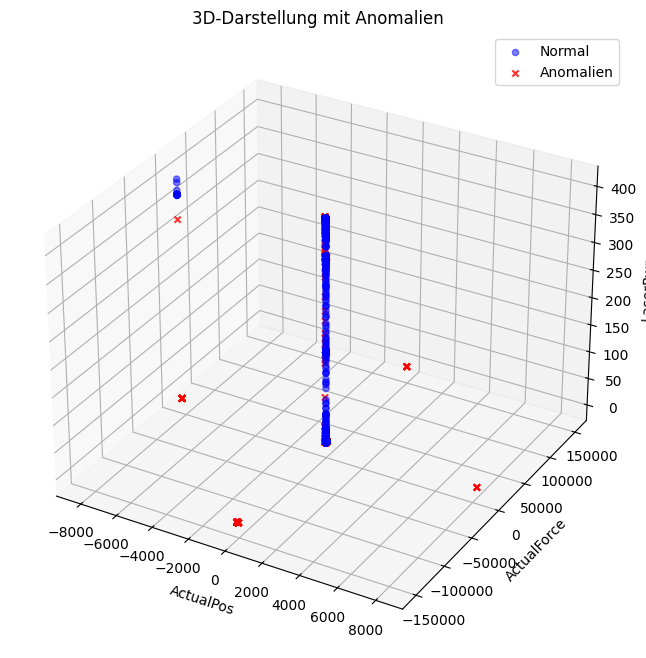

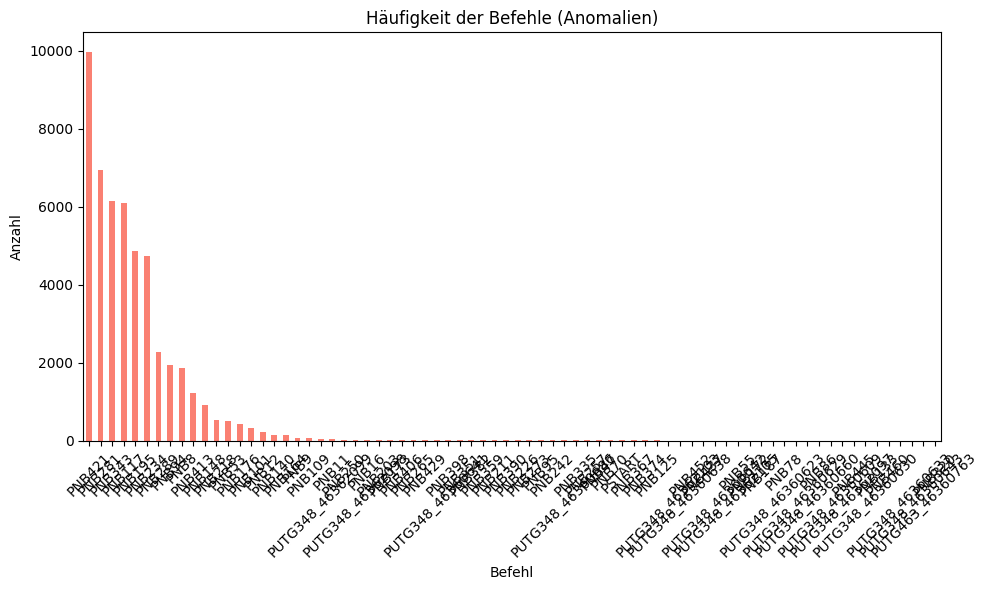

In [ ]:
# Verbindung zur SQLite-Datenbank herstellen
db_path = 'datenbank_clean.db'
conn = sqlite3.connect(db_path)

# Tabellen in der Datenbank auflisten
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Verfügbare Tabellen:", tables)

# Daten aus der Tabelle 'bereinigte_daten' laden
table_name = 'bereinigte_daten'
data = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)

# Überprüfen, ob die Spalte "Befehl" existiert
if 'Befehl' in data.columns:
    # Häufigkeitsanalyse der Spalte "Befehl"
    befehle_counts = data['Befehl'].value_counts()

    # Visualisierung: Balkendiagramm
    plt.figure(figsize=(10, 6))
    befehle_counts.plot(kind='bar', color='skyblue')
    plt.title('Häufigkeit der Befehle')
    plt.xlabel('Befehl')
    plt.ylabel('Anzahl')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Die Spalte 'Befehl' ist nicht in den Daten vorhanden.")

# Nur numerische Spalten auswählen
numeric_data = data.select_dtypes(include=[np.number])

# Überprüfen, ob mindestens drei numerische Spalten vorhanden sind
if numeric_data.shape[1] < 3:
    raise ValueError("Es werden mindestens drei numerische Spalten für die 3D-Darstellung benötigt.")

# Die ersten drei numerischen Spalten für die 3D-Darstellung auswählen
x_col, y_col, z_col = numeric_data.columns[:3]

# 3D-Plot der Daten
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(numeric_data[x_col], numeric_data[y_col], numeric_data[z_col], c='b', marker='o', alpha=0.5)
ax.set_xlabel(x_col)
ax.set_ylabel(y_col)
ax.set_zlabel(z_col)
ax.set_title("3D-Darstellung der numerischen Daten")
plt.show()

# Anomalien mit IsolationForest erkennen
iso_forest = IsolationForest(contamination=0.05, random_state=42)
numeric_data['anomaly'] = iso_forest.fit_predict(numeric_data)

# Anomalien markieren
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Normalpunkte (anomaly = 1)
normal_data = numeric_data[numeric_data['anomaly'] == 1]
ax.scatter(normal_data[x_col], normal_data[y_col], normal_data[z_col], c='b', marker='o', alpha=0.5, label='Normal')

# Anomalien (anomaly = -1)
anomalies = numeric_data[numeric_data['anomaly'] == -1]
ax.scatter(anomalies[x_col], anomalies[y_col], anomalies[z_col], c='r', marker='x', alpha=0.8, label='Anomalien')

ax.set_xlabel(x_col)
ax.set_ylabel(y_col)
ax.set_zlabel(z_col)
ax.set_title("3D-Darstellung mit Anomalien")
ax.legend()
plt.show()

# Häufigkeitsanalyse der Befehle und Anomalien in einem Diagramm überlagern
if 'Befehl' in data.columns and 'anomaly' in numeric_data.columns:
    # Häufigkeitsanalyse der Befehle
    befehle_counts = data['Befehl'].value_counts()

    # Anomalien filtern und Häufigkeitsanalyse der Befehle in den Anomalien
    anomalies_data = data.loc[numeric_data['anomaly'] == -1]
    anomalies_befehle_counts = anomalies_data['Befehl'].value_counts() if not anomalies_data.empty else pd.Series()

    # Kombiniertes Balkendiagramm
    plt.figure(figsize=(12, 6))
    befehle_counts.plot(kind='bar', color='skyblue', label='Alle Befehle', alpha=0.7)
    if not anomalies_befehle_counts.empty:
        anomalies_befehle_counts.plot(kind='bar', color='salmon', label='Anomalien', alpha=0.7)

    plt.title('Häufigkeit der Befehle (Alle vs. Anomalien)')
    plt.xlabel('Befehl')
    plt.ylabel('Anzahl')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Die Spalte 'Befehl' oder 'anomaly' ist nicht in den Daten vorhanden.")

# Verbindung zur Datenbank schließen
conn.close()